In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
%matplotlib inline

Скачиваем нужный датасет:

In [2]:
songs = pd.read_csv('https://stepik.org/media/attachments/course/4852/songs.csv')

И давайте на него посмотрим:

In [3]:
songs.head()

,song,year,artist,genre,lyrics,length,commas,exclamations,colons,hyphens
0,the-ownerz,2007,gangstarr,Hip-Hop,"""One-two..""\n""One-two, shots to the chin.. kno...",1300,24,5,0,11
1,dead-sound-of-misery,2006,blind-guardian,Metal,It's dark\nLet's do it now\nBring in the siren...,1566,0,0,0,0
2,modred-s-song,2006,blind-guardian,Metal,I've lost my battle before it starts\nmy first...,996,1,0,1,0
3,the-ninth-wave,2015,blind-guardian,Metal,As dark night embraces\nWe are the nation\nI w...,2868,5,0,0,0
4,skills,2014,gangstarr,Hip-Hop,"Skills, skills, skills\n""My Microphone""\n""It's...",3351,22,0,0,3


Его размер довольно-таки небольшой и нет пустых значений - это радует

In [4]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 10 columns):
song            360 non-null object
year            360 non-null int64
artist          360 non-null object
genre           360 non-null object
lyrics          360 non-null object
length          360 non-null int64
commas          360 non-null int64
exclamations    360 non-null int64
colons          360 non-null int64
hyphens         360 non-null int64
dtypes: int64(6), object(4)
memory usage: 28.2+ KB


В поле "lyrics" хранится текст песни целиком

In [5]:
songs['lyrics'][2]

"I've lost my battle before it starts\nmy first breath wasn't done\nmy spirit's sunken deep\ninto the ground\nwhy am I alone\nI can hear my heartbeat\nsilence's all around\nSee hat will rise\nso don't come closer\nfear your child\nborn with a king's heart\nbut fate fooled me\nand changed my cards\nnoone asked if I want it\nif I like it\nRef.:\nPain inside is rising\nI am the fallen one\na figure in an old game\nno Joker's on my side\nI plunged into misery\nI'll turn off the light\nand murder the dawn\nturn off the light\nand murder the dawn\nNothing else,\nbut laughter is around me\nforevermore\nnoone can heal me\nnothing can save me\nnoone can heal me\nI've gone beyond the truth\nit's just another lie\nwash away the blood on my hands\nmy father's blood\nin agony we're unified\nI never wanted to be\nwhat they told me to be\nfulfill my fate then I'll be free\ngod knows how long\nI tried to change fate\n(Solo)\nRef.\n(Solo)\nI plunged into misery\nI'll turn off the light\nand murder the 

Можем это проверить:

In [6]:
len(songs['lyrics'][2]) == songs['length'][2]

True

Итак, узнаем сколько всего у нас разных жанров:

In [7]:
songs[['genre']].drop_duplicates().count()

genre    3
dtype: int64

А сколько различных артистов?

In [8]:
songs[['artist']].drop_duplicates().count()

artist    3
dtype: int64

Хммм, можем предположить, что каждому артисту соответсвует свой, определённый стиль музыки:

In [9]:
songs[['artist', 'genre']].groupby('artist', as_index=False).agg({'genre' : 'nunique'})

,artist,genre
0,abba,1
1,blind-guardian,1
2,gangstarr,1


Так оно и есть

Итак, что мы имеем? У нас небольшой датасет, всего 3 автора. Каждому автору соответсвует свой жанр музыки. В каждоый песне посчитаны количество запятых(__commas__), восклицательных знаков(__exclamations__), двоеточий(__colons__) и дефисов(__hyphens__). А так же количество слов в песне(__length__). Относительно этих фичей нам нужно будет предсказывать артиста или жанр музыки, что в данном контексте одно и то же.

Предлагаю уже начинать

In [10]:
X = songs.drop(['song', 'year', 'artist', 'genre', 'lyrics'], axis=1)
y = songs[['artist']]

Подключим недостающие ф-ции:

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.36, random_state=42)

Ищем идеальную глубину дерева:

In [13]:
max_depth_values = range(1, 100)

score_data = pd.DataFrame()
for depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    cross_scores = cross_val_score(clf, X_train, y_train, cv=5).mean()
    
    temp_score_data = pd.DataFrame({'max_depth' : [depth], 
                                    'train_score' : [train_score],
                                    'test_score' : [test_score],
                                    'cross_scores' : cross_scores})
   
    
    score_data = score_data.append(temp_score_data)

In [14]:
score_data.head()

,max_depth,train_score,test_score,cross_scores
0,1,0.652174,0.561538,0.651950
0,2,0.700000,0.700000,0.669816
0,3,0.769565,0.746154,0.673882
0,4,0.795652,0.746154,0.643153
0,5,0.800000,0.738462,0.682582


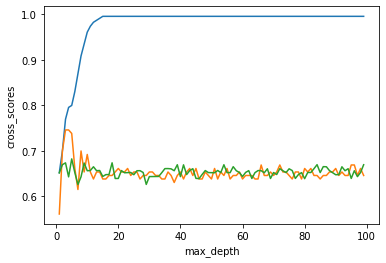

In [15]:
sns.lineplot('max_depth', 'train_score', data=score_data)
sns.lineplot('max_depth', 'test_score', data=score_data)
sns.lineplot('max_depth', 'cross_scores', data=score_data);

Наилучшая глубина дерева равна 5:

In [16]:
score_data[['max_depth', 'cross_scores']].sort_values(by='cross_scores', ascending=False).head(1)

,max_depth,cross_scores
0,5,0.682582


Обучаем на ней нашу модель:

In [17]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
clf.fit(X_train, y_train);

Давайте посмотрим на это дерево, интересно жи:

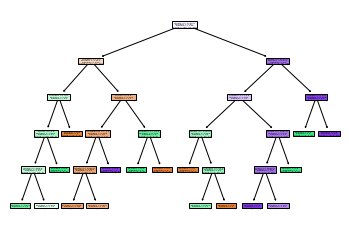

In [18]:
tree.plot_tree(clf, feature_names=list(X),filled=True);

![as](https://avatars.mds.yandex.net/get-pdb/875592/f78c2f6c-7abe-4446-8a58-4311d4c81000/s1200?webp=false)

Давайте выведим, хотя бы первые два шага:

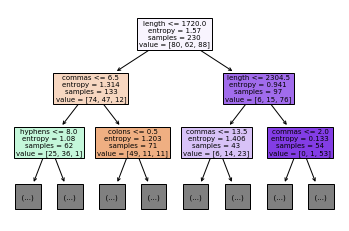

In [19]:
tree.plot_tree(clf, feature_names=list(X),filled=True, max_depth=2, fontsize=7);

Чуточку лучше...

Теперь протестируем процент попаданий на тестовой выборке:

In [20]:
clf.score(X_test, y_test)

0.7384615384615385

Вроде неплохо. Но, мне кажется, мы можем улучшить этот результат, если добавим доп. фичи, например, наиболее часто используемые слова в песнях у каждого автора. Однако в задаче у нас не стоит такой задачи. Поэтому оставим всё так как есть.

In [21]:
predictions = clf.predict(X_test)

In [22]:
from sklearn.metrics import precision_score

Осталось посчитать precision:

In [23]:
precision_score(y_test, predictions, average='micro')

0.7384615384615385

Вы восхитительны!